# Exploratory Data Analysis Challenge: Factors that affect life expectancy

Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the __[Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home)__ from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

- postgres_user = 'dsbc_student'
- postgres_pw = '7*.8G9QH21'
- postgres_host = '142.93.121.174'
- postgres_port = '5432'
- postgres_db = 'lifeexpectancy'
- table_name = 'lifeexpectancy'

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it. To complete this challenge, follow these steps:

1. First, load the dataset.
2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.
3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.
4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.
5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

### 1. Loading the Dataset

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

age_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

### 2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

_Getting a Feel for the Dataframe_

In [3]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

_Deciding Which Variables to Keep_

I found a WHO list of __[100 Core Health Indicators](https://www.who.int/healthinfo/indicators/2015/100CoreHealthIndicators_2015_infographic.pdf?ua=1)__ and compared it to the variables in the dataframe. I found that the following variables aren't core health indicators, so I'll drop them from the dataframe: 1. Measles; 2. Polio; 3. Diphtheria; 4. GDP; 5. Population; 6. Thinness 1-19 years; 7. Income Composition of Resources; and 8. Schooling.

In [4]:
age_df_dropped_columns = age_df[['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 
                                 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', ' BMI ',
                                 'under-five deaths ', 'Total expenditure', ' HIV/AIDS', ' thinness 5-9 years']]

_Missing Information_

In [5]:
(age_df_dropped_columns.isnull().sum()*100) / age_df_dropped_columns.isnull().count()

Country                    0.000000
Year                       0.000000
Status                     0.000000
Life expectancy            0.340368
Adult Mortality            0.340368
infant deaths              0.000000
Alcohol                    6.603131
percentage expenditure     0.000000
Hepatitis B               18.822328
 BMI                       1.157250
under-five deaths          0.000000
Total expenditure          7.692308
 HIV/AIDS                  0.000000
 thinness 5-9 years        1.157250
dtype: float64

It may not be a good idea to use interpolation to replace the missing values because the countries are sorted alphabetically and healthy countries could be placed next to unhealthy ones, which could skew the data. Given that, I'll use the mean to fill in missing data because it's a representative of the central tendency. 

In [6]:
age_df_no_nans = age_df_dropped_columns.copy()

replace_nans_with_means_list = ['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Total expenditure', 
                                ' HIV/AIDS', ' thinness 5-9 years']

for col in replace_nans_with_means_list:
    age_df_no_nans.fillna(age_df_no_nans[replace_nans_with_means_list].mean(), inplace=True)

_Outliers_

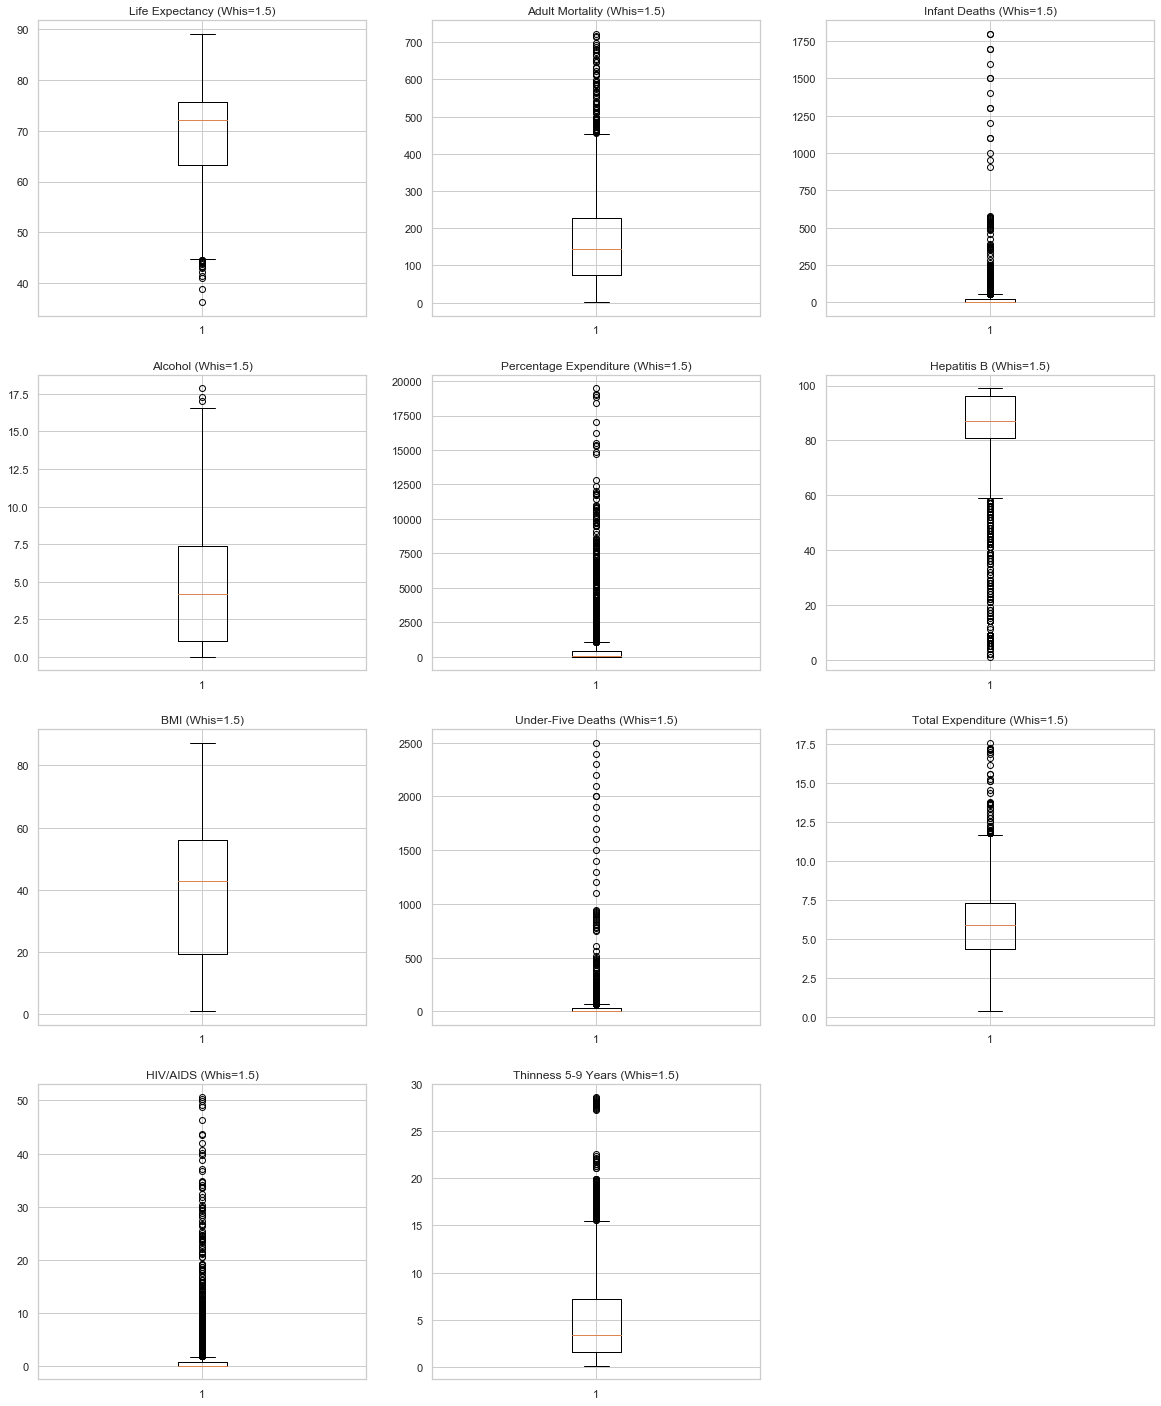

In [7]:
plt.figure(figsize=(20, 25))

plt.subplot(4, 3, 1)
plt.boxplot(age_df_no_nans['Life expectancy '], whis=1.5)
plt.title('Life Expectancy (Whis=1.5)')

plt.subplot(4, 3, 2)
plt.boxplot(age_df_no_nans['Adult Mortality'], whis=1.5)
plt.title('Adult Mortality (Whis=1.5)')

plt.subplot(4, 3, 3)
plt.boxplot(age_df_no_nans['infant deaths'], whis=1.5)
plt.title('Infant Deaths (Whis=1.5)')

plt.subplot(4, 3, 4)
plt.boxplot(age_df_no_nans['Alcohol'], whis=1.5)
plt.title('Alcohol (Whis=1.5)')

plt.subplot(4, 3, 5)
plt.boxplot(age_df_no_nans['percentage expenditure'], whis=1.5)
plt.title('Percentage Expenditure (Whis=1.5)')

plt.subplot(4, 3, 6)
plt.boxplot(age_df_no_nans['Hepatitis B'], whis=1.5)
plt.title('Hepatitis B (Whis=1.5)')

plt.subplot(4, 3, 7)
plt.boxplot(age_df_no_nans[' BMI '], whis=1.5)
plt.title('BMI (Whis=1.5)')

plt.subplot(4, 3, 8)
plt.boxplot(age_df_no_nans['under-five deaths '], whis=1.5)
plt.title('Under-Five Deaths (Whis=1.5)')

plt.subplot(4, 3, 9)
plt.boxplot(age_df_no_nans['Total expenditure'], whis=1.5)
plt.title('Total Expenditure (Whis=1.5)')

plt.subplot(4, 3, 10)
plt.boxplot(age_df_no_nans[' HIV/AIDS'], whis=1.5)
plt.title('HIV/AIDS (Whis=1.5)')

plt.subplot(4, 3, 11)
plt.boxplot(age_df_no_nans[' thinness 5-9 years'], whis=1.5)
plt.title('Thinness 5-9 Years (Whis=1.5)')

plt.show()

All the variables have many outliers except for Alcohol and BMI (BMI doesn't have any outliers). I'll use Tukey's Method to use statistics to take a closer look at Alcohol's outliers.

In [8]:
q75, q25 = np.percentile(age_df_no_nans['Alcohol'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1, 2.5, 0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print('- The score threshold is: {}'.format(threshold))
    print('- Number of outliers for Alcohol is: {}'.format(
        len((np.where((age_df_no_nans['Alcohol'] > max_val) 
                      | (age_df_no_nans['Alcohol'] < min_val))[0]))
    ))

- The score threshold is: 1.0
- Number of outliers for Alcohol is: 25
- The score threshold is: 1.5
- Number of outliers for Alcohol is: 3
- The score threshold is: 2.0
- Number of outliers for Alcohol is: 0


_Impacts of the Outliers_

The outliers could skew the data and have a negative impact on the data analysis. I don't want to drop or winsorize the data because I could lose information (and it's important to me to look at countries across the whole spectrum), so I'll transform it to make it more closely match a normal distribution.

In [9]:
age_df_log_transformed = age_df_no_nans.copy()

log_transform_list = ['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 
                      'Hepatitis B', 'under-five deaths ', 'Total expenditure', ' HIV/AIDS', ' thinness 5-9 years']

for col in log_transform_list:
    np.log(age_df_log_transformed[log_transform_list]) 

### 3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

_Univariate Exploration_

In [10]:
age_df_log_transformed.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,BMI,under-five deaths,Total expenditure,HIV/AIDS,thinness 5-9 years
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,38.321247,42.035739,5.938190,1.742103,4.870317
std,4.613841,9.507640,124.080302,117.926501,3.916288,1987.914858,22.586855,19.927677,160.445548,2.400274,5.077785,4.482708
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,1.000000,0.000000,0.370000,0.100000,0.100000
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,80.940461,19.400000,0.000000,4.370000,0.100000,1.600000
50%,2008.000000,72.000000,144.000000,3.000000,4.160000,64.912906,87.000000,43.000000,4.000000,5.938190,0.100000,3.400000
75%,2012.000000,75.600000,227.000000,22.000000,7.390000,441.534144,96.000000,56.100000,28.000000,7.330000,0.800000,7.200000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,87.300000,2500.000000,17.600000,50.600000,28.600000


In [11]:
age_df_log_transformed['Life expectancy '].median()

72.0

_Multivariate Exploration_

In [12]:
status = age_df_log_transformed['Status'].unique()
grouped_df = age_df_log_transformed.groupby('Status')
for var in ['Life expectancy ']:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(status)):
        for j in range(i+1, len(status)):
            print("t-test between groups {0} and {1}:".format(status[i], status[j]))
            print(stats.ttest_ind(
                age_df_log_transformed[age_df_log_transformed['Status']==status[i]][var], 
                age_df_log_transformed[age_df_log_transformed['Status']==status[j]][var]
            ))

------------------------------------------------
Comparisons for variable: Life expectancy 
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=-29.805188781530223, pvalue=9.034938663789684e-171)


In [13]:
status = age_df_log_transformed['Status'].unique()
grouped_df = age_df_log_transformed.groupby('Status')
for var in [' HIV/AIDS']:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(status)):
        for j in range(i+1, len(status)):
            print("t-test between groups {0} and {1}:".format(status[i], status[j]))
            print(stats.ttest_ind(
                age_df_log_transformed[age_df_log_transformed['Status']==status[i]][var], 
                age_df_log_transformed[age_df_log_transformed['Status']==status[j]][var]
            ))

------------------------------------------------
Comparisons for variable:  HIV/AIDS
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=8.14171501118477, pvalue=5.697077437253885e-16)


Text(0.5, 1, 'Correlation Matrix for the Life Expectancy Data')

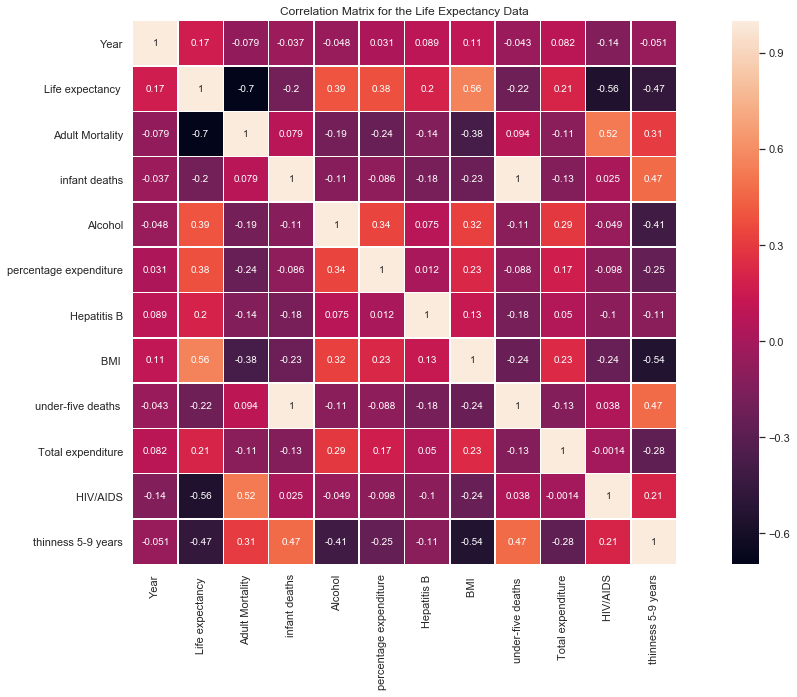

In [14]:
corrmat_age_df = age_df_log_transformed.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corrmat_age_df, square=True, annot=True, linewidths=0.5)
plt.title('Correlation Matrix for the Life Expectancy Data')

### 4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

_Making a New Variable with the Expenditure Data_

In [15]:
age_df_entries = 2938

age_df_log_transformed['Health Expenditure'] = ((age_df_log_transformed['percentage expenditure']*0.5) +
                                                (age_df_log_transformed['Total expenditure']*0.5)) / age_df_entries

_Discarding Variables_

- The correlation matrix showed that the six key variables impacting Life Expectancy are: 
    1. Adult Mortality (-0.7 correlation coefficient {CC}) 
    2. HIV/AIDS (-0.56 CC)
    3. Thinness 5-9 Years (-0.47 CC)
    4. Health Expenditure (0.38 CC)
    5. Alcohol (0.39 CC)
    6. BMI (0.56 CC)

- Because the following variables had a CC between -0.25 to 0.25 with Life Expectancy, they'll be dropped from the dataframe: 
    1. Under-Five Deaths (-0.22 CC)
    2. Infant Deaths (-0.2 CC)
    3. Year (0.17 CC)
    4. Hepatitis B (0.2 CC).
    
Please note: the Status variable will be left in because there's an interesting link between Status and Life Expectancy that I'll cover in the findings.

In [16]:
age_df_log_transformed_dropped_columns = age_df_log_transformed[['Country', 'Status', 'Life expectancy ', ' HIV/AIDS',
                                                                ' thinness 5-9 years', 'Health Expenditure', 'Alcohol',
                                                                ' BMI ', 'Adult Mortality']]

### 5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

_A Note About Life Expectancy and Country Status_

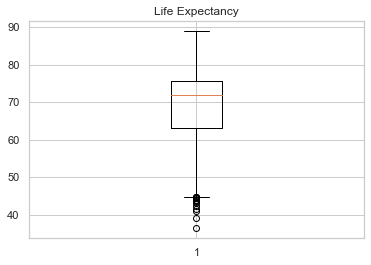

In [17]:
plt.boxplot(age_df_log_transformed_dropped_columns['Life expectancy '], whis=1.5)
plt.title('Life Expectancy')
plt.show()

To give perspective to the findings that will be discussed, it's important to note that the WHO's data showed that across the globe, the median age to live to is 72, while the average person lives to be 69. The minimum age recorded was 36 and the maximum was 89; however, even after transforming the data, there are still outliers that may be pulling the average down.
The conclusions of how those factors relate to life expectancy are detailed below.

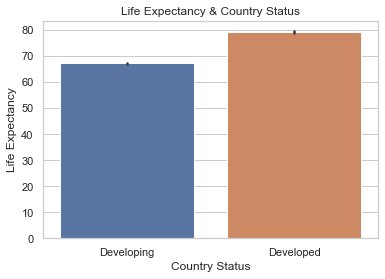

In [27]:
sns.barplot(age_df_log_transformed_dropped_columns['Status'], 
            age_df_log_transformed_dropped_columns['Life expectancy '])
plt.xlabel('Country Status')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy & Country Status')

plt.show()

Further, there's a statistically significant connection between life expectancy and a country's status as a developing or developed country in that people who live in developed countries have longer life expectancies.

With the notes about life expectancy and country status in mind, the key variables that impact life expectancy are: 1. Adult mortality, 2. Thinness in children and BMI, 3. HIV/AIDs, 4. Acohol and 5. Health expenditure.

The conclusions of how those factors relate to life expectancy are detailed below.

_1. Adult Mortality had the Largest Impact on Life Expectancy_

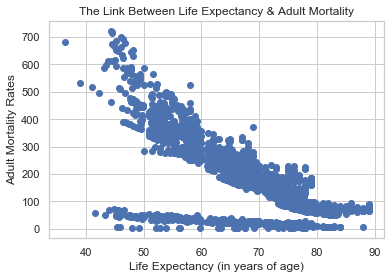

In [32]:
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '], 
            age_df_log_transformed_dropped_columns['Adult Mortality'])
plt.xlabel('Life Expectancy (in years of age)')
plt.ylabel('Adult Mortality Rates')
plt.title('The Link Between Life Expectancy & Adult Mortality')

plt.show()

This graph shows two distinct groups, one whose trend line would be relatively flat and another whose line is downward sloping. Overall, though, there's a negative correlation between life expectancy adnd adult mortality rates.

Which means that as people move into higher age brackets, the population shrinks and the mortality rate goes down because the population pool is getting smaller.

_2. Thinness in Children & BMI_

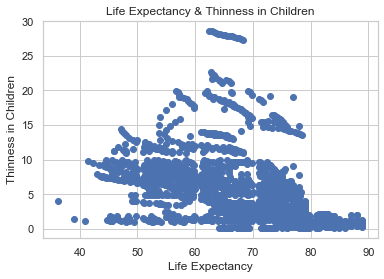

In [19]:
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '],
            age_df_log_transformed_dropped_columns[' thinness 5-9 years'])
plt.xlabel('Life Expectancy')
plt.ylabel('Thinness in Children')
plt.title('Life Expectancy & Thinness in Children')

plt.show()

The less underweight a child is, the longer their life expectancy will be. This could be an indicator that an effective way to increase lifespans would be to focus on childhood intervention and ensure that childrens' caloric and nutritional needs are being met early on.

As a side note, this graph shows multiple dot clusters close together, which could show data points from individual countries that are changing year over year; however, since this graph doesn't include time, it's not clear if the countries' populations are getting healthier with time.

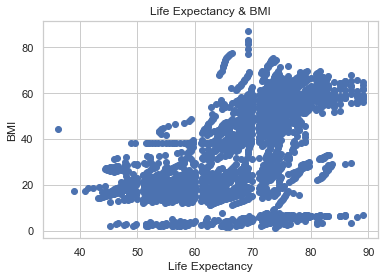

In [21]:
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '],
            age_df_log_transformed_dropped_columns[' BMI '])
plt.xlabel('Life Expectancy')
plt.ylabel('BMI')
plt.title('Life Expectancy & BMI')

plt.show()

BMI has a positive relationship with Life Expectancy and as the population's BMI rose, life expectancy rose as well. Given that obesity is a global epidemic, that finding was a surprise.

Another interesting feature in this graph was that there are two distinct groups of values. It could be valuable to do further research to see if the groups are different world regions.

_3. HIV/AIDs_

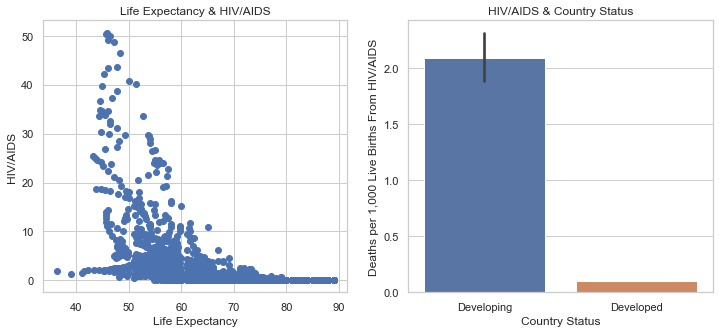

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '],
            age_df_log_transformed_dropped_columns[' HIV/AIDS'])
plt.xlabel('Life Expectancy')
plt.ylabel('HIV/AIDS')
plt.title('Life Expectancy & HIV/AIDS')

plt.subplot(1, 2, 2)
sns.barplot(age_df_log_transformed_dropped_columns['Status'], 
            age_df_log_transformed_dropped_columns[' HIV/AIDS'])
plt.xlabel('Country Status')
plt.ylabel('Deaths per 1,000 Live Births From HIV/AIDS')
plt.title('HIV/AIDS & Country Status')

plt.show()

As the number of deaths per 1,000 live births from HIV/AIDS decreases, life expectancy increases. Further, there's a statistically significant connection between deaths from HIV/AIDS and a country's status as developing and developed (please see the Multivariate Exploration in section three).

_4. Alcohol_

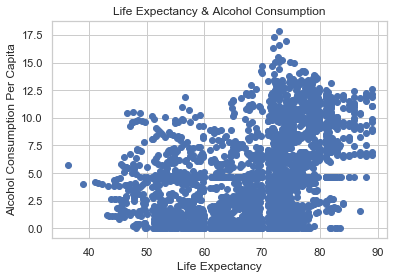

In [24]:
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '],
            age_df_log_transformed_dropped_columns['Alcohol'])
plt.xlabel('Life Expectancy')
plt.ylabel('Alcohol Consumption Per Capita')
plt.title('Life Expectancy & Alcohol Consumption')

plt.show()

Surprisingly, there's a positive correlation between alcohol consumption and life expectancy.

This could be linked to other factors, such as a wealth. For example, if an individual can afford to buy alcohol, they may also be able to afford a lifestyle that includes going to the gym and eating healthy food.

_5. Health Expenditure_

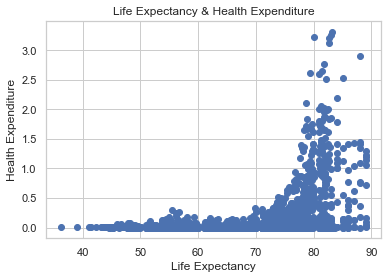

In [25]:
plt.scatter(age_df_log_transformed_dropped_columns['Life expectancy '],
            age_df_log_transformed_dropped_columns['Health Expenditure'])
plt.xlabel('Life Expectancy')
plt.ylabel('Health Expenditure')
plt.title('Life Expectancy & Health Expenditure')

plt.show()

Some countries are getting high life expectancy with cost effective expenditures, while other countries are spending large amounts of money, but aren't getting a bump in life expectancy.

Countries which have increased health expenditures, but not increased life expectancies, may have expensive healthcare systems and populations with health issues that are costly to treat.